In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aydafrough","key":"6f11d390d25b1f8e7987d65c72badb9a"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/global-youtube-statistics-2023                     Global YouTube Statistics 2023                       60KB  2023-07-28 15:36:38           7636        247  1.0              
joebeachcapital/world-happiness-report-2013-2023                    World Happiness Reports 2013-2023                    93KB  2023-08-15 01:09:41            734         26  1.0              
nagrajdesai/latest-10000-movies-dataset-from-tmdb                   Latest 10000 Movies Dataset from TMDB                 1MB  2023-08-17 04:45:36            700         31  1.0              
nelgiriyewithana/countries-of-the-world-

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:10<00:00, 32.6MB/s]
100% 2.29G/2.29G [01:10<00:00, 35.1MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from pathlib import Path
from typing import List,Dict

In [8]:
train_path=Path('chest_xray/train')
test_path=Path('chest_xray/test')
val_path=Path('chest_xray/val')


In [9]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
import random
from PIL import Image

image_list=[]
image_list_path=list(test_path.glob("*/*.jpeg"))
for i in range(10):
  image_path=random.choice(image_list_path)
  image_class=image_path.parent.stem
  img=Image.open(image_path)

  image_list.append({'img':img, 'image_class':image_class})


image_list

[{'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1538x1202>,
  'image_class': 'NORMAL'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1512x888>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1742x1392>,
  'image_class': 'NORMAL'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1072x800>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1184x648>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1072x560>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1112x736>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2001x1725>,
  'image_class': 'NORMAL'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1336x1040>,
  'image_class': 'PNEUMONIA'},
 {'img': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1184x96

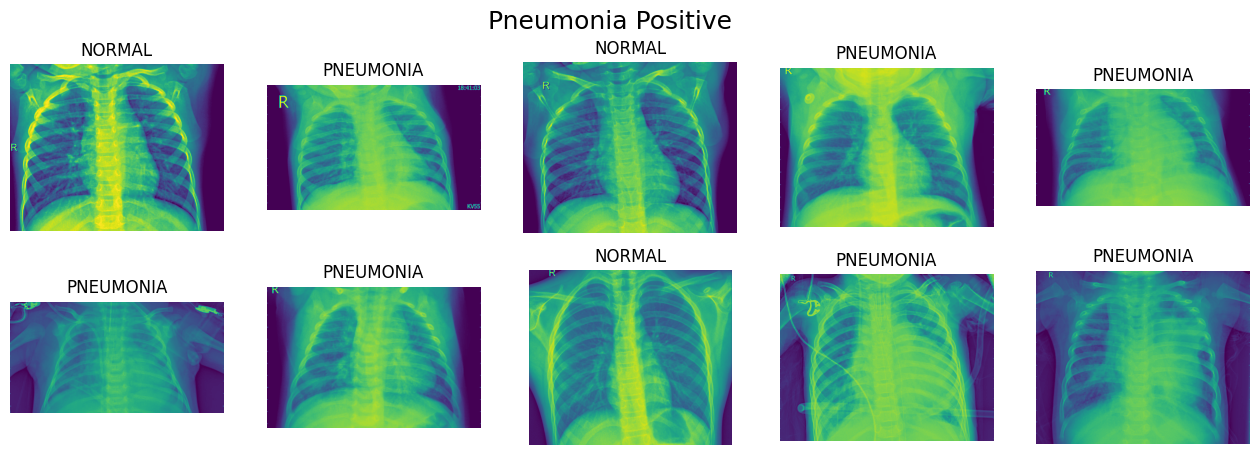

In [11]:
#visualize our data
fig = plt.figure(figsize=(16,5))
fig.suptitle("Pneumonia Positive", size=18)
for i, image in enumerate(image_list):
  #fig.add_subplot(2,5,len(image_list),frameon=False)
  plt.subplot(2,5,i+1,frameon=False)
  plt.imshow(image["img"])
  plt.title(image["image_class"])
  plt.axis(False)



fig.show()

In [12]:
#set transforms
normalize=transforms.Normalize(mean=[0.485,0.456,0.406],
                               std=[0.229,0.224,0.225])
data_transform= transforms.Compose([
    transforms.Resize(size=(150,150)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normalize
])

In [13]:
#prepare datasets

train_data= datasets.ImageFolder(root=train_path,transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_path,transform=data_transform)
eval_data=datasets.ImageFolder(root=val_path,transform=data_transform)


In [14]:
class_names=train_data.classes
class_names

['NORMAL', 'PNEUMONIA']

In [15]:
#get the dataloaders
import os
batch_size=32
num_workers=os.cpu_count()
train_dataloader=DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_dataloader=DataLoader(dataset=test_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
eval_dataloader=DataLoader(dataset=eval_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f2d9037f310>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2d9037fa30>)

models

1.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1 	86.012 /98.054 /83.6M /46.73

2.Swin_V2_T_Weights.IMAGENET1K_V1 	82.072 / 96.132 / 28.4M / 5.94

3.EfficientNet_B3_Weights.IMAGENET1K_V1 82.008 /96.054 /12.2M /1.83

4.RegNet_X_1_6GF_Weights.IMAGENET1K_V2 	79.668 /94.922 /9.2M /1.6

5.EfficientNet_V2_S_Weights.IMAGENET1K_V1  84.228 / 96.878 /21.5M /8.37


In [16]:
weights=torchvision.models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1
model=torchvision.models.regnet_y_16gf(weights=weights)

model

Downloading: "https://download.pytorch.org/models/regnet_y_16gf_swag-43afe44d.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_16gf_swag-43afe44d.pth
100%|██████████| 319M/319M [00:08<00:00, 38.7MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [18]:
weights=torchvision.models.Swin_V2_T_Weights.IMAGENET1K_V1
model_1=torchvision.models.swin_v2_t(weights=weights).to(device)
for param in model_1.parameters():
  param.requires_grad=False
model_1

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

In [19]:
model_1.head=nn.Linear(in_features=768, out_features=len(class_names), bias=True)
model_1.to(device)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

In [20]:
weights=torchvision.models.EfficientNet_B3_Weights.IMAGENET1K_V1
model_2=torchvision.models.efficientnet_b3(weights=weights)
for param in model_2.parameters():
  param.requires_grad=False
model_2

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 157MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [21]:
model_2.classifier=nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=len(class_names), bias=True)
  ).to(device)

In [22]:
weights=torchvision.models.RegNet_X_1_6GF_Weights.IMAGENET1K_V2
model_3=torchvision.models.regnet_x_1_6gf(weights=weights)
for param in model_3.parameters():
  param.requires_grad=False
model_3

Downloading: "https://download.pytorch.org/models/regnet_x_1_6gf-a12f2b72.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_1_6gf-a12f2b72.pth
100%|██████████| 35.3M/35.3M [00:00<00:00, 157MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            

In [23]:
model_3.fc=nn.Linear(in_features=912, out_features=len(class_names), bias=True).to(device)

In [24]:
model.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [25]:
#freeze
for param in model.parameters():
  param.requires_grad=False


In [26]:
#torch info library install
! pip install torchinfo

In [27]:
from torchinfo import summary
#n_inputs = model.classifier[6].in_features
model.fc= nn.Linear(in_features=3024, out_features=len(class_names), bias=True)
# Add on classifier
#model.classifier[6] = nn.Sequential( nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, len(class_names)), nn.LogSoftmax(dim=1))
model.to(device)
summary(model=model,
        input_size=(32,3,224,224),#batch size, color channels height, width
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 2]              --                   Partial
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 3024, 7, 7]     --                   False
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32, 

In [28]:
summary(model=model_1,
        input_size=(32,3,224,224),#batch size, color channels height, width
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 7, 7, 768]      --                   False
│    └─Sequential (0)                                   [32, 3, 224, 224]    [32, 56, 56, 96]     --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     (4,704)              False
│    │    └─Permute (1)                                 [32, 96, 56, 56]     [32, 56, 56, 96]     --                   --
│    │    └─LayerNorm (2)                               [32, 56, 56, 96]     [32, 56, 56, 96]     (192)                False
│    └─Sequential (1)                                   [32, 56, 56, 96]     [32, 56, 56, 96]     --                   Fal

In [29]:
summary(model=model_2,
        input_size=(32,3,224,224),#batch size, color channels height, width
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1536, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 40, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 40, 112, 112]   (1,080)              False
│    │    └─BatchNorm2d (1)                                  [32, 40, 112, 112]   [32, 40, 112, 112]   (80)                 False
│    │    └─SiLU (2)                                         [32, 40, 112, 112]   [32, 40, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 40, 112, 112]   [32, 

In [30]:
summary(model=model_3,
        input_size=(32,3,224,224),#batch size, color channels height, width
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                    [32, 3, 224, 224]    [32, 2]              --                   Partial
├─SimpleStemIN (stem)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNorm2d (1)                             [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    └─ReLU (2)                                    [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                        [32, 32, 112, 112]   [32, 912, 7, 7]      --                   False
│    └─AnyStage (block1)                           [32, 32, 112, 112]   [32, 72, 56, 56]     --                   False
│    │    └─ResBottleneckBlock (block

In [31]:
#install torch metrics
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 8.4 MB/s eta 0:00:00


In [32]:
from torchmetrics import Accuracy


loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
accuracy=Accuracy(task='binary', num_classes=len(class_names)).to(device)


In [33]:
def train_fun(dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn,
              model:torch.nn.Module,
              optimizer:torch.optim,
              accuracy,
              device):
  model.train()

  train_loss,train_acc=0,0
  for batch, (x,y) in enumerate(dataloader):

    x,y=x.to(device),y.to(device)

    y_pred=model(x)

    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    acc=accuracy(torch.argmax(torch.softmax(y_pred, dim=1),dim=1), y)
    train_acc+=acc.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss= train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)


  return train_loss, train_acc











In [34]:
def test_fun(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_fn:torch.nn,
             accuracy,
             device):
  test_loss,test_acc=0,0

  model.eval()
  with torch.inference_mode():

    for batch, (x,y) in enumerate(dataloader):

      x,y= x.to(device) , y.to(device)

      y_pred=model(x)

      loss=loss_fn(y_pred,y)
      test_loss+=loss.item()
      acc= accuracy(torch.argmax(torch.softmax(y_pred,dim=1), dim=1), y)
      test_acc+= acc.item()


  test_loss= test_loss/len(dataloader)
  test_acc=test_acc/len(dataloader)


  return test_loss, test_acc




In [35]:
#functionize the looping through train and test steps
from tqdm.auto import tqdm
def train_test(model:torch.nn.Module,
               train_dataloader:torch.utils.data.DataLoader,
               test_dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn,
               optimizer:torch.optim,
               accuracy,
               device,
               epochs):
  results={"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}

  for epoch in range(epochs):

    train_loss,train_acc=train_fun(dataloader=train_dataloader,loss_fn=loss_fn,model=model,optimizer=optimizer,accuracy=accuracy,device=device)






    test_loss,test_acc=test_fun(model=model,dataloader=test_dataloader,loss_fn=loss_fn,accuracy=accuracy,device=device)


    #print
    print(f"epoch:{epoch} , Train_loss: {train_loss}, Train_accuracy: {train_acc},Test_loss: {test_loss}, Test_accuracy: {test_acc},")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


In [36]:
from timeit import default_timer as timer
start_time=timer()

model0_results= train_test(model=model,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                           loss_fn=loss_fn,
                           optimizer=optimizer,
                           accuracy=accuracy,
                           device=device,
                           epochs=5)

end_time=timer()
print(f"train time: {end_time- start_time:.3f} seconds")
#best train loss: 0.13
#best train accuracy:0.95
#best test loss:0.43
#best test accuracy:0.85
#5 epochs

epoch:0 , Train_loss: 0.24640721641480923, Train_accuracy: 0.9091257668711656,Test_loss: 0.6141120970249176, Test_accuracy: 0.7921875,
epoch:1 , Train_loss: 0.18263982344944418, Train_accuracy: 0.9334739263803681,Test_loss: 0.43877808675169944, Test_accuracy: 0.840625,
epoch:2 , Train_loss: 0.16527198057084636, Train_accuracy: 0.9390337423312883,Test_loss: 1.002736684679985, Test_accuracy: 0.7453125,
epoch:3 , Train_loss: 0.13208087596562376, Train_accuracy: 0.9484279141104295,Test_loss: 0.4847995642572641, Test_accuracy: 0.853125,
epoch:4 , Train_loss: 0.13408925166593555, Train_accuracy: 0.9507285276073619,Test_loss: 0.726144888997078, Test_accuracy: 0.80625,
train time: 480.944 seconds


In [37]:
#plot loss and accuracy
def plot_loss_curves(results:Dict[str, List[float]]):
  #plot training curves of a results dictionary
  #get the loss values of teh results dictionary(train, test)

  loss=results["train_loss"]
  test_loss =results["test_loss"]

  #get the accuracy of the results dictionary
  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]

  #figure out how many epochs there were
  epochs= range(len(results["train_loss"]))

  # set up plot
  plt.figure(figsize=(7,7))
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

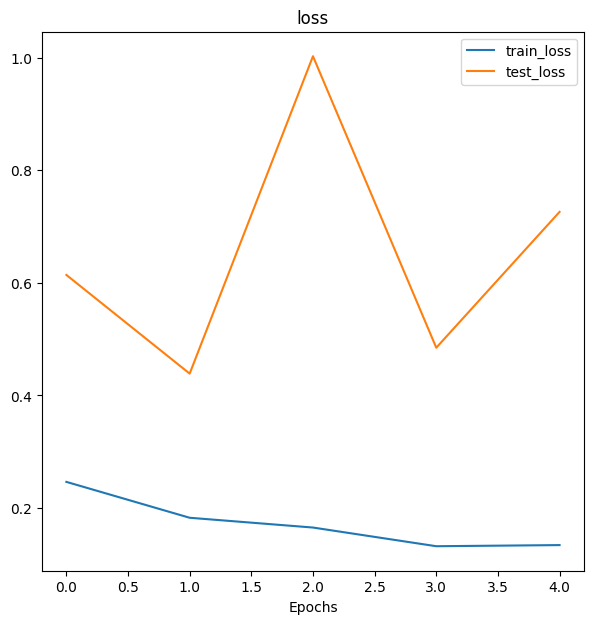

In [38]:
plot_loss_curves(model0_results)

In [40]:
#model_2 train test
optimizer_2=torch.optim.Adam(params=model_2.parameters(),lr=0.001)
from timeit import default_timer as timer
start_time=timer()
results_2=train_test(model=model_2,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer_2,
                     accuracy=accuracy,
                     device=device,
                     epochs=10)
end_time=timer()
print(f"train time: {end_time- start_time:.3f} seconds")
#best train loss: 0.17
#best train accuracy:0.929
#best test loss:0.39
#best test accuracy:0.81
#train time: 803.721 seconds

epoch:0 , Train_loss: 0.3278921724645638, Train_accuracy: 0.8709739263803681,Test_loss: 0.46939861625432966, Test_accuracy: 0.775,
epoch:1 , Train_loss: 0.22572240434541294, Train_accuracy: 0.9156441717791411,Test_loss: 0.41189564391970634, Test_accuracy: 0.7984375,
epoch:2 , Train_loss: 0.2060085845414115, Train_accuracy: 0.9206288343558282,Test_loss: 0.44251122176647184, Test_accuracy: 0.7953125,
epoch:3 , Train_loss: 0.20092169428529916, Train_accuracy: 0.9204371165644172,Test_loss: 0.4490276113152504, Test_accuracy: 0.8,
epoch:4 , Train_loss: 0.19250347906369372, Train_accuracy: 0.9265720858895705,Test_loss: 0.4281740374863148, Test_accuracy: 0.80625,
epoch:5 , Train_loss: 0.17784337980524162, Train_accuracy: 0.9290644171779141,Test_loss: 0.39191984459757806, Test_accuracy: 0.815625,
epoch:6 , Train_loss: 0.18550259334269475, Train_accuracy: 0.9252300613496932,Test_loss: 0.4548195093870163, Test_accuracy: 0.790625,
epoch:7 , Train_loss: 0.19142317319391694, Train_accuracy: 0.923696

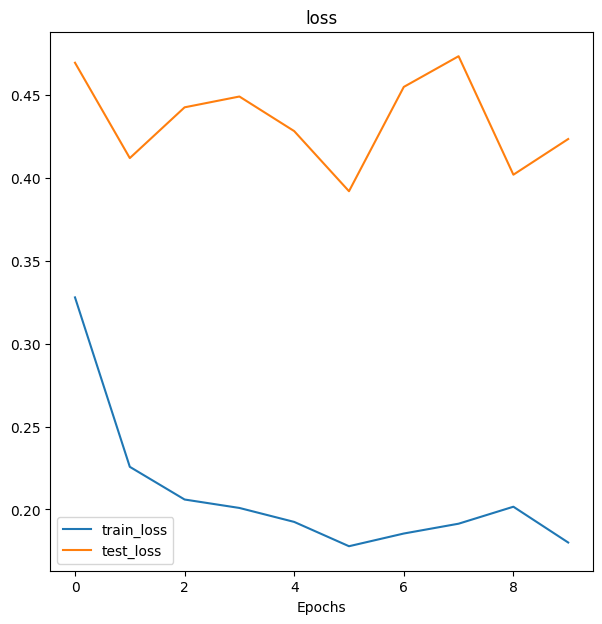

In [41]:
plot_loss_curves(results_2)

In [42]:
#model_3 train test
optimizer_3=torch.optim.Adam(params=model_3.parameters(),lr=0.001)
from timeit import default_timer as timer
start_time=timer()
results_3=train_test(model=model_3,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer_3,
                     accuracy=accuracy,
                     device=device,
                     epochs=10)
end_time=timer()
print(f"train time: {end_time- start_time:.3f} seconds")
#best train loss: 0.11
#best train accuracy:0.956
#best test loss:0.41
#best test accuracy:0.84
#train time: 831.914 seconds

epoch:0 , Train_loss: 0.3109369353374089, Train_accuracy: 0.8744248466257669,Test_loss: 0.41215747222304344, Test_accuracy: 0.7984375,
epoch:1 , Train_loss: 0.19215457662482935, Train_accuracy: 0.9267638036809815,Test_loss: 0.47984772101044654, Test_accuracy: 0.7921875,
epoch:2 , Train_loss: 0.16810237079218854, Train_accuracy: 0.9351993865030674,Test_loss: 0.5248496070504188, Test_accuracy: 0.7796875,
epoch:3 , Train_loss: 0.1521449325823345, Train_accuracy: 0.941909509202454,Test_loss: 0.4382004402577877, Test_accuracy: 0.8171875,
epoch:4 , Train_loss: 0.14441153660782277, Train_accuracy: 0.9478527607361963,Test_loss: 0.5185248009860516, Test_accuracy: 0.8015625,
epoch:5 , Train_loss: 0.14305841253121937, Train_accuracy: 0.9451687116564417,Test_loss: 0.3909460328519344, Test_accuracy: 0.8453125,
epoch:6 , Train_loss: 0.13740942266089784, Train_accuracy: 0.9468941717791411,Test_loss: 0.42403136715292933, Test_accuracy: 0.84375,
epoch:7 , Train_loss: 0.1277071666429562, Train_accuracy:

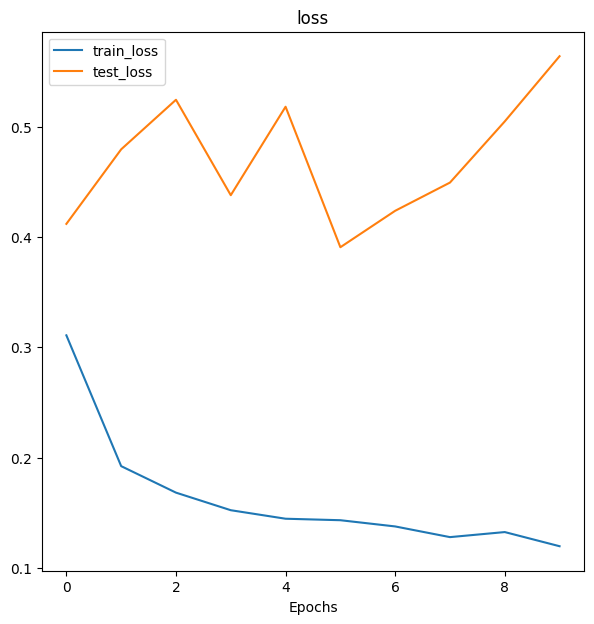

In [43]:
plot_loss_curves(results_3)

In [44]:
#model_1 train test
optimizer_1=torch.optim.Adam(params=model_1.parameters(),lr=0.001)
from timeit import default_timer as timer
start_time=timer()
results_1=train_test(model=model_1,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer_1,
                     accuracy=accuracy,
                     device=device,
                     epochs=10)
end_time=timer()
print(f"train time: {end_time- start_time:.3f} seconds")
#best train loss: 0.10
#best train accuracy:0.958
#best test loss:0.38
#best test accuracy:0.853
#train time: 820.078 seconds

epoch:0 , Train_loss: 0.2579679930685488, Train_accuracy: 0.8953220858895705,Test_loss: 0.4286825850605965, Test_accuracy: 0.8109375,
epoch:1 , Train_loss: 0.1681088287086209, Train_accuracy: 0.9363496932515337,Test_loss: 0.3816512681543827, Test_accuracy: 0.840625,
epoch:2 , Train_loss: 0.15150227498240265, Train_accuracy: 0.9415260736196319,Test_loss: 0.406499096006155, Test_accuracy: 0.8375,
epoch:3 , Train_loss: 0.13670645906744194, Train_accuracy: 0.9482361963190185,Test_loss: 0.4909051276743412, Test_accuracy: 0.8015625,
epoch:4 , Train_loss: 0.130109393580651, Train_accuracy: 0.9501533742331288,Test_loss: 0.4580817870795727, Test_accuracy: 0.8234375,
epoch:5 , Train_loss: 0.1296775306580714, Train_accuracy: 0.9513036809815951,Test_loss: 0.5763631112873554, Test_accuracy: 0.7921875,
epoch:6 , Train_loss: 0.1191394360038949, Train_accuracy: 0.9555214723926381,Test_loss: 0.4881282590329647, Test_accuracy: 0.8234375,
epoch:7 , Train_loss: 0.11414955442119962, Train_accuracy: 0.95667

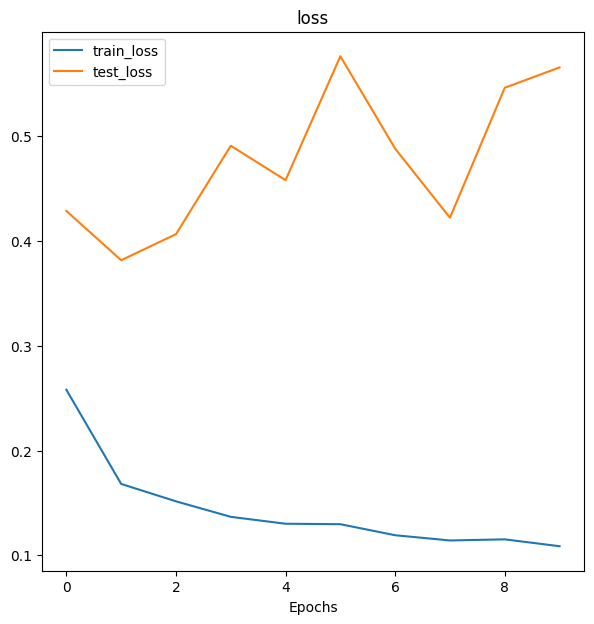

In [45]:
plot_loss_curves(results_1)